<a href="https://colab.research.google.com/github/Ali-Asgar-Lakdawala/Forcasting/blob/main/Monthly_milk_production_forcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import pandas as pd

In [150]:
df=pd.read_csv('https://raw.githubusercontent.com/Ali-Asgar-Lakdawala/Forcasting/main/data/monthlyMilkProduction.csv')

In [151]:
df['Month']=pd.to_datetime(df['Month'])

In [152]:
df=df.set_index(df['Month']).drop('Month',axis=1)

In [153]:
df

,Monthly milk production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


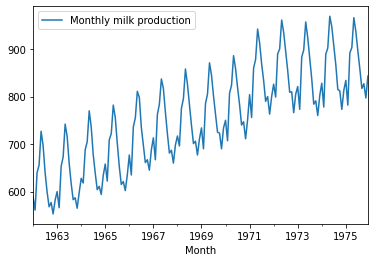

In [154]:
df.plot()

In [155]:
from statsmodels.tsa.stattools import adfuller

In [156]:
adfuller(df['Monthly milk production'])

(-1.3038115874221299,
 0.6274267086030314,
 13,
 154,
 {'1%': -3.473542528196209,
  '10%': -2.576878053634677,
  '5%': -2.880497674144038},
 1115.1730447395112)

In [157]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [158]:
adfuller_test(df['Monthly milk production'])

ADF Test Statistic : -1.3038115874221299
p-value : 0.6274267086030314
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [159]:
df['first_dif']=df['Monthly milk production']-df['Monthly milk production'].shift(1)
df['seasonal_dif']=df['first_dif']-df['first_dif'].shift(12)

In [160]:
adfuller_test(df['seasonal_dif'].dropna())

ADF Test Statistic : -5.038002274921983
p-value : 1.865423431878848e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [161]:
df['seasonal_dif']

Month
1962-01-01     NaN
1962-02-01     NaN
1962-03-01     NaN
1962-04-01     NaN
1962-05-01     NaN
              ... 
1975-08-01     3.0
1975-09-01    11.0
1975-10-01    13.0
1975-11-01     9.0
1975-12-01     6.0
Name: seasonal_dif, Length: 168, dtype: float64

In [162]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [163]:
import matplotlib.pyplot as plt


p,d,q p

p AR model lags 
 
d differencing 
 
q MA lags

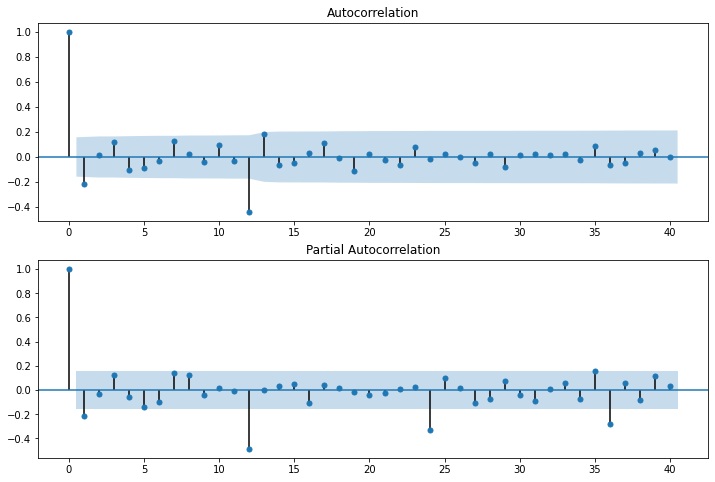

In [164]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['seasonal_dif'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['seasonal_dif'].iloc[13:],lags=40,ax=ax2)

In [165]:
# setting initial values and some bounds for them
ps = range(1, 4)
d=1 
qs = range(1, 4)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 12 # season length is still 24

# creating list with all the possible combinations of parameters
from itertools import product 
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [166]:
import statsmodels.api as sm

In [167]:
# from statsmodels.api.tsa.stattools import SARIMAX
from tqdm import tqdm_notebook
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for ps, qs, Ps, Qs in parameters_list:
      # we need try-except because on some combinations model fails to converge
      
      model=sm.tsa.statespace.SARIMAX(df['Monthly milk production'], order=(ps, d, qs),seasonal_order=(Ps, D, Qs, s))
      model=model.fit()   

      aic = model.aic
      # saving best model, AIC and parameters
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = ps, qs, Ps, Qs
      results.append([[ps, qs, Ps, Qs], model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [168]:
# %%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

In [169]:
result_table.head()

,parameters,aic
0,"[2, 1, 0, 1]",1066.695673
1,"[1, 3, 0, 1]",1067.982420
2,"[1, 1, 0, 1]",1068.063954
3,"[2, 2, 0, 1]",1068.466615
4,"[2, 1, 1, 1]",1068.472069


In [170]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df['Monthly milk production'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                 Statespace Model Results                                 
Dep. Variable:            Monthly milk production   No. Observations:                  168
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -528.348
Date:                            Sat, 29 Jan 2022   AIC                           1066.696
Time:                                    07:26:28   BIC                           1081.913
Sample:                                01-01-1962   HQIC                          1072.877
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1558      0.097    -11.874      0.000      -1.347      -0.965
ar.L2         -0.2629      0.085   

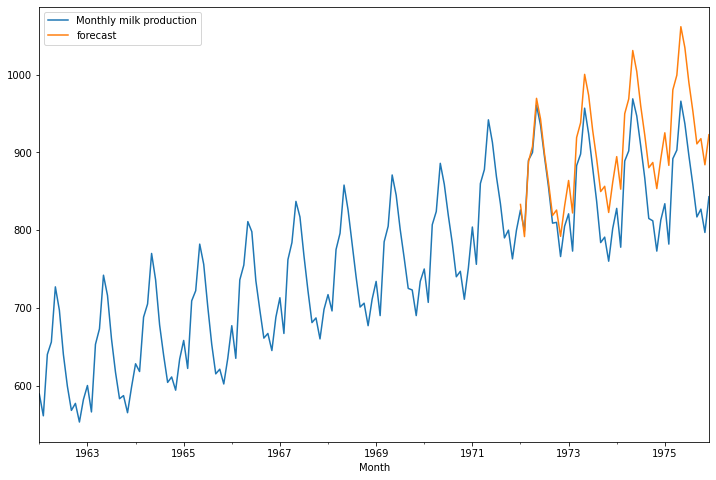

In [173]:
df['forecast']=best_model.predict(start=120,end=190,dynamic=True)
df[['Monthly milk production','forecast']].plot(figsize=(12,8))


In [174]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [175]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [176]:
future_df=pd.concat([df,future_datest_df])

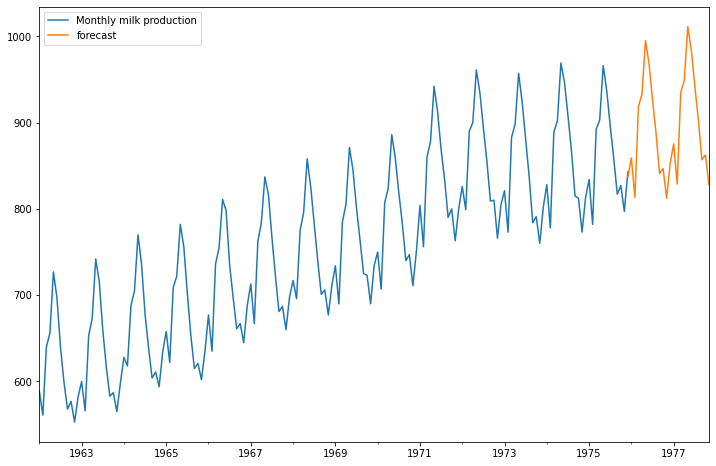

In [181]:
future_df['forecast']=best_model.predict(start=167,end=190,dynamic=True)
future_df[['Monthly milk production','forecast']].plot(figsize=(12,8))
